This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noisy image data

## load required packages and test data

In [5]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Random
using Revise, MDToolbox
ENV["COLUMNS"] = 150; #display width for MDToolbox

In [6]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip nx ny surfs images images_randn

In [7]:
tip

10×10 Matrix{Float64}:
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -223.495  -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -223.495  -308.564
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -427.927  -379.253  -341.33    -3

In [8]:
MDToolbox.translate_tip_mean(tip)

10×10 Matrix{Float64}:
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -223.495  -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -223.495  -308.564
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -427.927  -379.253  -341.33    -3

## Define Flux layers

In [9]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(ierosion(image, m.P), m.P)

## loop over lambda

In [10]:
nframe = 20
nrealization = 100
Random.seed!(777);
loss_over_lambdas_array = []
lossp_over_lambdas_array = []
P_over_lambdas_array = []
#lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]

for irealization = 1:nrealization
    @info irealization

    for iframe = 1:length(images)
        images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
    end
    images_randn_copy = deepcopy(images_randn)

    loss_over_lambdas = []
    lossp_over_lambdas = []
    P_over_lambdas = []

    for lambda in lambdas
        @info lambda

        m = IOpen(ny, nx)

        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( m.P.^2 )
        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
        loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))
        lossp(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( m.P.^2 )

        ps = Flux.params(m)

        train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:nframe], label=images_randn[1:nframe]), batchsize=1, shuffle=false);

        #opt = ADAM(0.1)
        opt = ADAMW(1.0, (0.9, 0.999), lambda)
    
        loss_train = []
        lossp_train = []

        for epoch in 1:200
            for (x, y) in train_loader
                gs = gradient(() -> loss(x, y), ps)
                Flux.Optimise.update!(opt, ps, gs)
                m.P .= min.(m.P, 0.0)
                m.P .= MDToolbox.translate_tip_mean(m.P)
                #m.P .= MDToolbox.translate_tip_peak(m.P)
            end
            push!(loss_train, loss(images_randn_copy[1:nframe], images_randn[1:nframe]))
            push!(lossp_train, lossp(images_randn_copy[1:nframe], images_randn[1:nframe]))
        end

        push!(loss_over_lambdas, loss_train[end])
        push!(lossp_over_lambdas, lossp_train[end])
        push!(P_over_lambdas, m.P)
    end
    
    push!(loss_over_lambdas_array, loss_over_lambdas)
    push!(lossp_over_lambdas_array, lossp_over_lambdas)
    push!(P_over_lambdas_array, P_over_lambdas)
end

┌ Info: 1
└ @ Main In[10]:11
┌ Info: 1.0e-7
└ @ Main In[10]:23
┌ Info: 1.0e-6
└ @ Main In[10]:23
┌ Info: 1.0e-5
└ @ Main In[10]:23
┌ Info: 0.0001
└ @ Main In[10]:23
┌ Info: 0.001
└ @ Main In[10]:23
┌ Info: 0.01
└ @ Main In[10]:23
┌ Info: 2
└ @ Main In[10]:11
┌ Info: 1.0e-7
└ @ Main In[10]:23
┌ Info: 1.0e-6
└ @ Main In[10]:23
┌ Info: 1.0e-5
└ @ Main In[10]:23
┌ Info: 0.0001
└ @ Main In[10]:23
┌ Info: 0.001
└ @ Main In[10]:23
┌ Info: 0.01
└ @ Main In[10]:23
┌ Info: 3
└ @ Main In[10]:11
┌ Info: 1.0e-7
└ @ Main In[10]:23
┌ Info: 1.0e-6
└ @ Main In[10]:23
┌ Info: 1.0e-5
└ @ Main In[10]:23
┌ Info: 0.0001
└ @ Main In[10]:23
┌ Info: 0.001
└ @ Main In[10]:23
┌ Info: 0.01
└ @ Main In[10]:23
┌ Info: 4
└ @ Main In[10]:11
┌ Info: 1.0e-7
└ @ Main In[10]:23
┌ Info: 1.0e-6
└ @ Main In[10]:23
┌ Info: 1.0e-5
└ @ Main In[10]:23
┌ Info: 0.0001
└ @ Main In[10]:23
┌ Info: 0.001
└ @ Main In[10]:23
┌ Info: 0.01
└ @ Main In[10]:23
┌ Info: 5
└ @ Main In[10]:11
┌ Info: 1.0e-7
└ @ Main In[10]:23
┌ Info: 1.0e-6
└ 

In [12]:
loss_over_lambdas_array[1]

6-element Vector{Any}:
   5.28758624892072
   3.5721672131560576
   1.537785853674918
   1.7241136223432452
  12.190377985914996
 142.35407386606843

In [13]:
tip

10×10 Matrix{Float64}:
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -223.495  -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -223.495  -308.564
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -427.927  -379.253  -341.33    -3

In [14]:
P_over_lambdas_array[1][1]

10×10 Matrix{Float64}:
 -111.086  -115.935   -111.333   -107.311    -116.56      -106.058    -115.632   -116.477  -124.394  -112.185
 -122.726  -111.6     -105.91    -119.71     -126.459     -114.796    -105.535   -119.219  -112.948  -113.667
 -116.392  -120.054   -113.655    -75.6713    -55.2912     -72.587    -108.111   -112.271  -114.479  -115.89
 -108.567  -103.477    -73.3552    -8.77944    -0.293663    -9.65941   -70.1221  -108.651  -116.078  -124.003
 -106.03    -95.2374   -53.07      -6.2426     -7.90291      0.0       -50.1513  -115.716  -112.117  -123.723
 -107.288  -108.148    -73.65      -9.91692    -5.4356      -9.62898   -74.2619  -109.713  -123.333  -123.674
 -115.658  -109.062    -98.7788   -79.8475    -51.9002     -72.3622   -101.144   -116.468  -117.183  -119.127
 -112.169  -111.984   -105.453   -103.77      -98.4584    -107.363    -117.333   -110.16   -112.424  -113.411
 -110.122  -112.134   -116.194   -108.498    -110.775     -116.453    -108.1     -118.731  -117.59

In [10]:
#gr()

In [11]:
#heatmap(tip)

In [12]:
#heatmap(P_over_lambdas_array[1][1])

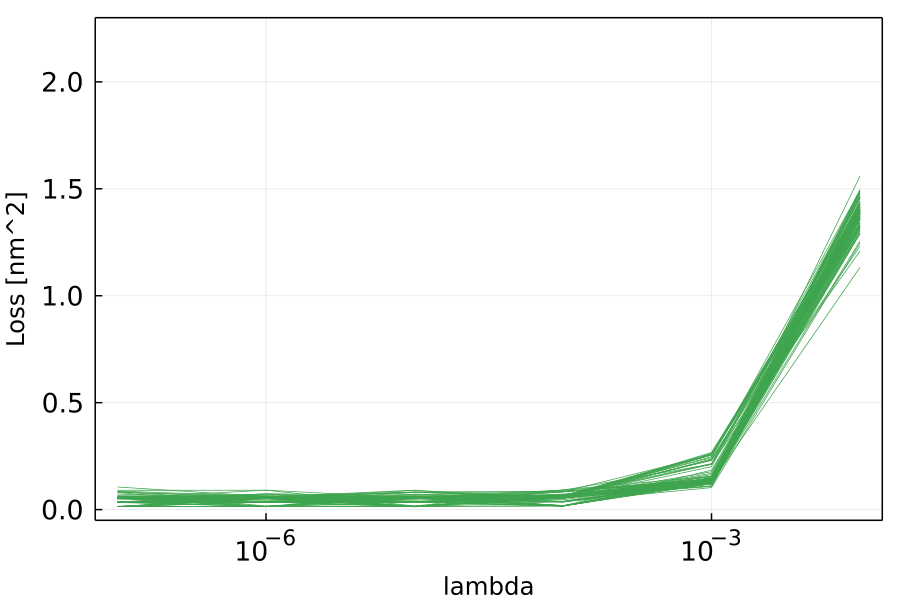

In [25]:
plot(lambdas, loss_over_lambdas_array[1] ./ 100.0, xaxis=:log, framestyle=:box, 
     xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=0.5, dpi=150, fmt=:png, color=3, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

l_mean = deepcopy(loss_over_lambdas_array[1] ./ 100.0)
for i = 2:nrealization
    plot!(lambdas, loss_over_lambdas_array[i] ./ 100.0, xaxis=:log, framestyle=:box, xlabel="threshold T", ylabel="loss [nm^2]", 
          label=nothing, linewidth=0.5, dpi=150, fmt=:png, color=3)
    l_mean .+= (loss_over_lambdas_array[i] ./ 100.0)
end
l_mean .= l_mean ./ nrealization

l_std = deepcopy(l_mean)
l_std .= 0.0
for i = 1:nrealization
    l_std .+= ((loss_over_lambdas_array[i] ./ 100.0) .- l_mean).^2
end
l_std .= l_std ./ (nrealization - 1.0)

#plot!(lambdas, l_mean, ribbon=l_std, fillalpha=0.5, color=3, linewidth=0.0, legend=nothing)

ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
ylabel!("Loss [nm^2]", fontsize=35)

In [26]:
savefig(p, "blindtip_opening_randn01.png")

In [27]:
#gr()

In [28]:
tip

10×10 Matrix{Float64}:
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -223.495  -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -223.495  -308.564
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -427.927  -379.253  -341.33    -3

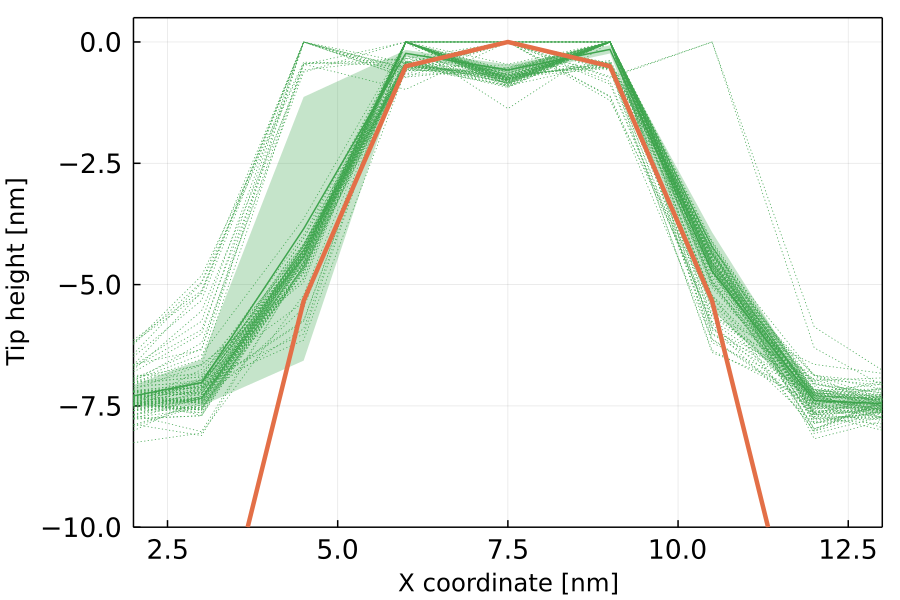

In [29]:
it = 5
islice = 5
cutoff = 80.0

plot(collect(1:nx) .* resolution ./ 10.0, P_over_lambdas_array[1][it][islice, :] / 10.0, linewidth=0.5, linestyle=:dot, color=3, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
p_mean = deepcopy(P_over_lambdas_array[1][it][islice, :] ./ 10.0)
for irealization = 2:nrealization
    plot!(collect(1:nx) .* resolution ./ 10.0, P_over_lambdas_array[irealization][it][islice, :] / 10.0, linewidth=0.5, linestyle=:dot, color=3, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    p_mean .+= P_over_lambdas_array[irealization][it][islice, :] ./ 10.0
end
p_mean .= p_mean ./ nrealization

p_std = deepcopy(p_mean)
p_std .= 0.0
for irealization = 1:nrealization
    p_std .+= (P_over_lambdas_array[irealization][it][islice, :] ./ 10.0 .- p_mean).^2
end
p_std .= p_std ./ (nrealization - 1.0)

plot!(collect(1:nx) .* resolution ./ 10.0, p_mean, ribbon=p_std, fillalpha=0.3, color=3)

plot!((collect(1:nx)) .* resolution ./ 10.0, tip[islice, :] ./ 10.0, linewidth=3, label="ground truth", legend=nothing, color=2, 
      xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

ylims!((-10, 0.5))
xlims!((2, 13))
xlabel!("X coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [30]:
savefig(p, "blindtip_opening_randn02.png")

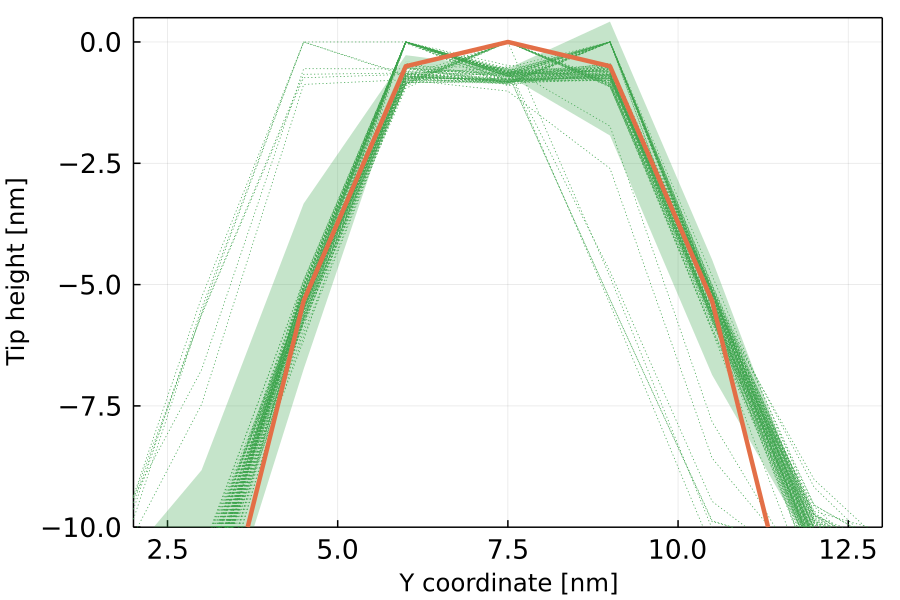

In [31]:
it = 1
islice = 5

plot(collect(1:ny) .* resolution ./ 10.0, P_over_lambdas_array[1][it][:, islice] / 10.0, 
    linewidth=0.5, linestyle=:dot, color=3, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
p_mean = deepcopy(P_over_lambdas_array[1][it][:, islice] ./ 10.0)
for irealization = 2:nrealization
    plot!(collect(1:ny) .* resolution / 10.0, P_over_lambdas_array[irealization][it][:, islice] ./ 10.0, 
        linewidth=0.5, linestyle=:dot, color=3, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    p_mean .+= P_over_lambdas_array[irealization][it][:, islice] ./ 10.0
end
p_mean .= p_mean ./ nrealization

p_std = deepcopy(p_mean)
p_std .= 0.0
for irealization = 1:nrealization
    p_std .+= (P_over_lambdas_array[irealization][it][:, islice] ./ 10.0 .- p_mean).^2
end
p_std .= p_std ./ (nrealization - 1.0)

plot!(collect(1:ny) .* resolution ./ 10.0, p_mean, ribbon=p_std, fillalpha=0.3, color=3, linewidth=0.0)

plot!((collect(1:ny)) .* resolution ./ 10.0, tip[:, islice] / 10.0, linewidth=3, label="ground truth", legend=nothing, color=2, 
      xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

ylims!((-10, 0.5))
xlims!((2, 13))

xlabel!("Y coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [32]:
tip

10×10 Matrix{Float64}:
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -223.495  -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -223.495  -308.564
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -427.927  -379.253  -341.33    -3

In [33]:
savefig(p, "blindtip_opening_randn03.png")

In [34]:
#pyplot()

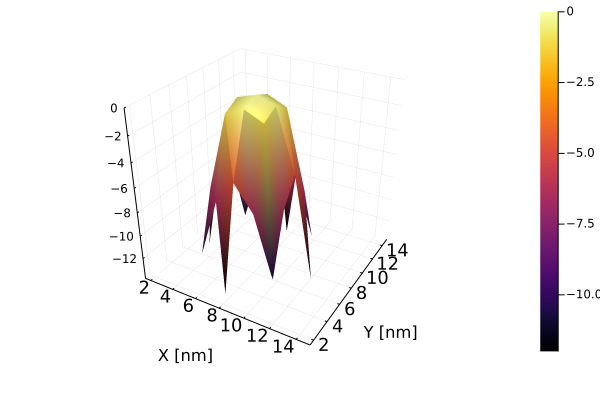

In [35]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:nx) .* resolution ./ 10.0, collect(1:ny) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clims=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X [nm]", fontsize=35)
p = ylabel!("Y [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [36]:
savefig(p, "blindtip_opening_randn04.png")

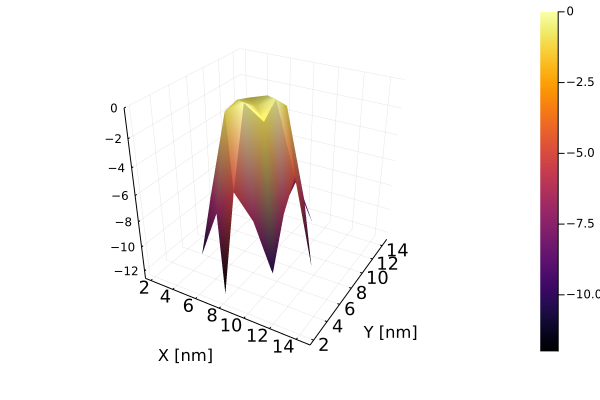

In [37]:
it = 1
ireal = 1
tip_tmp = deepcopy(P_over_lambdas_array[ireal][it])
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:nx) .* resolution ./ 10.0, collect(1:ny) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clims=(-12, 0), 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X [nm]", fontsize=35)
p = ylabel!("Y [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [38]:
savefig(p, "blindtip_opening_randn05.png")

In [39]:
#gr()

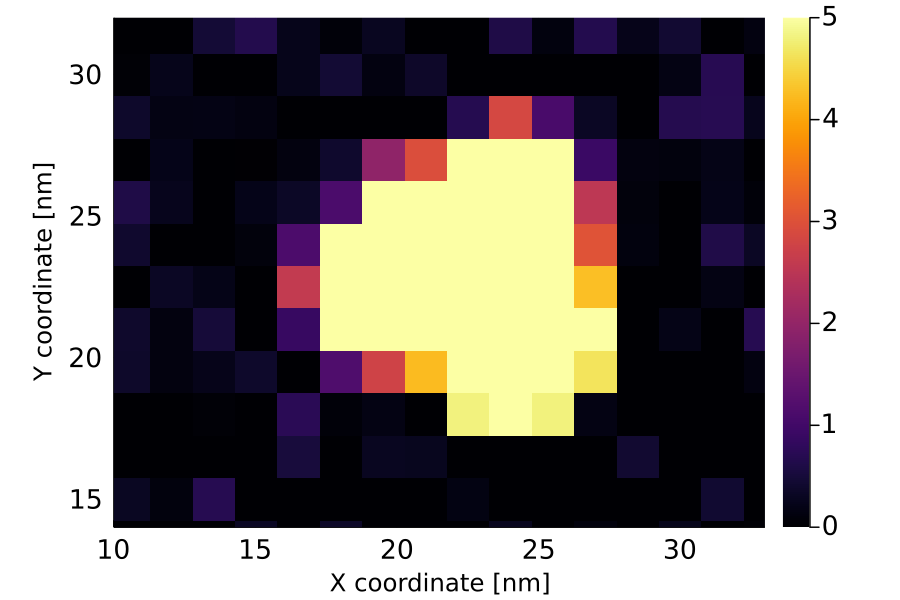

In [40]:
p = heatmap(collect(1:30) .* resolution ./ 10.0, collect(1:30) .* resolution ./ 10.0, images_randn[1] ./ 10.0, clim=(0, 5), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [41]:
savefig(p, "blindtip_opening_randn06.png")

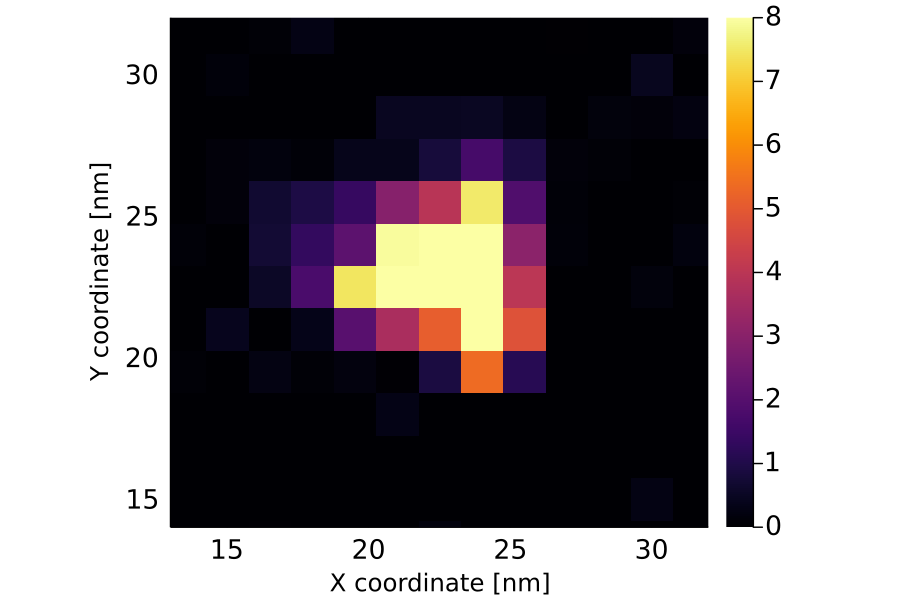

In [42]:
p = heatmap(collect(1:30) .* resolution ./ 10.0, collect(1:30) .* resolution ./ 10.0, ierosion(images_randn[1], P_over_lambdas_array[1][1]) ./ 10.0, clim=(0, 8), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [43]:
savefig(p, "blindtip_opening_randn07.png")

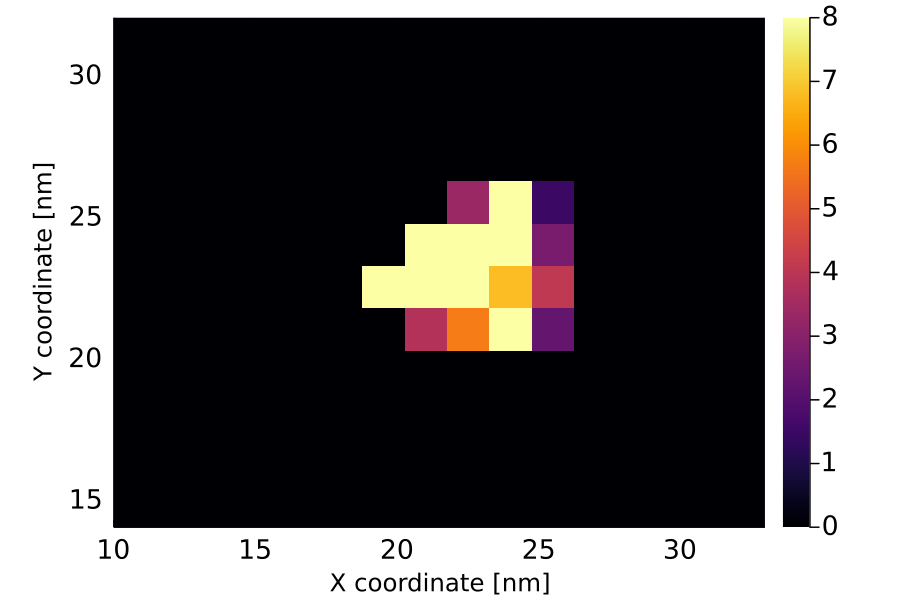

In [44]:
p = heatmap(collect(1:30) .* resolution ./ 10.0, collect(1:30) .* resolution ./ 10.0, surfs[1] ./ 10.0, clim=(0, 8), dpi=150, fmt=:png,
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [45]:
savefig(p, "blindtip_opening_randn08.png")

# Pixel RMSD of reconstructed tip

In [46]:
function pixel_rmsd(image1, image2, ref; cutoff = -70.0)
    image1_shifted = similar(image1)

    rmsd_min = Inf64
    for du = -5:5, dv = -5:5
        image1_shifted = circshift(image1, (du, dv))
        #id = (image1_shifted .> cutoff) .| (image2 .> cutoff)
        id = ref .> cutoff
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

diff_tip = zeros(Float64, length(lambdas)*nrealization, 2)
count = 0
for it = 1:length(lambdas)
    for ireal = 1:nrealization
        c = pixel_rmsd(P_over_lambdas_array[ireal][it], tip, tip, cutoff=-80.0)
        count += 1
        diff_tip[count, 1] = lambdas[it]
        diff_tip[count, 2] = c
    end
end

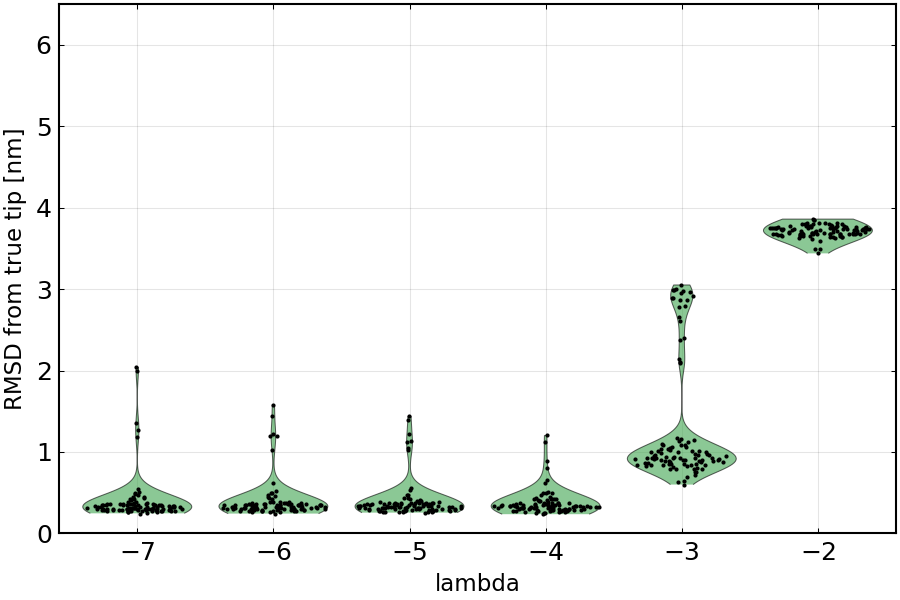

In [47]:
using StatsPlots
pyplot()

violin(log10.(diff_tip[:, 1]), diff_tip[:, 2] / 10.0, ylim=(-0.1, 6.0), #xaxis=:log, 
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=3)

dotplot!(log10.(diff_tip[:, 1]), diff_tip[:, 2] / 10.0, marker=(:black,stroke(0)), mode = :density, markersize=2.0, label=nothing)

#scatter(diff_tip[:, 1] / 10.0, diff_tip[:, 2] / 10.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
#        xtickfontsize=12, ytickfontsize=12, legendfontsize=10, colorbar_tickfontsize=10, markersize=12, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
p = ylabel!("RMSD from true tip [nm]", fontsize=35)
ylims!(0.0, 6.5)

# Pixel RMSD of reconstructed surface

In [48]:
diff_surf = zeros(Float64, length(lambdas)*nrealization*nframe, 2)
count = 0
Random.seed!(777);
images_randn = deepcopy(images)

for it = 1:length(lambdas)
    for ireal = 1:nrealization
        for iframe = 1:nframe
            images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
            c = pixel_rmsd(ierosion(images_randn[iframe], P_over_lambdas_array[ireal][it]), surfs[iframe], images[iframe], cutoff=10.0)
            count += 1
            diff_surf[count, 1] = lambdas[it]
            diff_surf[count, 2] = c
        end
    end
end

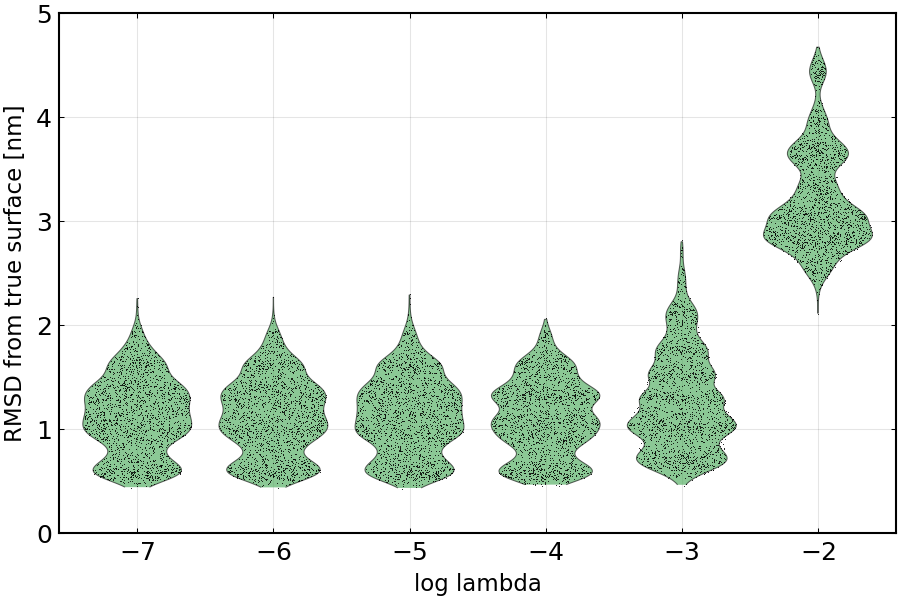

In [49]:
using StatsPlots
pyplot()

violin(log10.(diff_surf[:, 1]), diff_surf[:, 2] / 10.0, ylim=(-0.1, 6.0),
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       xlabel="log lambda", ylabel="RMSD from true surface [nm]", 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=3)

dotplot!(log10.(diff_surf[:, 1]), diff_surf[:, 2] / 10.0, marker=(:black, stroke(0)), markersize=0.5, mode = :density, label=nothing)

ylims!(-0.0, 5)

# Save results

In [50]:
using BSON: @save, @load

@save "blindtip_opening_randn.bson" tip images nframe nrealization lambdas P_over_lambdas_array diff_tip diff_surf 